In [19]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import ugradio
import astropy
import os
from matplotlib import colors

LT_LAT, LT_LON, LT_ALT = ugradio.leo.lat, ugradio.leo.lon, ugradio.leo.alt

mpl.rcParams['axes.linewidth'] = 3 #set the value globally
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

# Load in Data

In [2]:
# CODE TO LOAD SPECTRA NUMPY FILES IN A DICT

data_dict = {} # dict where key is coordinate (l, b)) and value is [main, noise_on, noise_off, [ra, dec, jd]]
                # where main, noise_on, noise_off are all numpy arrays of the spectra
for filename in os.listdir('New_Data/celestial_data/'):
    if filename == ".ipynb_checkpoints" or filename == '.DS_Store':
        continue
        
    split_name = filename.split("_")

    if split_name[0] == 'off':
        fits_type = 2 # off
        save_name = filename[3:]
    elif split_name[0] == 'on':
        fits_type = 1 # on
        save_name = filename[2:]
    else:
        fits_type = 0 # main
        save_name = filename[4:]
    
    
    #l, b, ra, dec, jd
    _, l, b, ra, dec, jd, _ = split_name
    l, b, ra, dec, jd = float(l), float(b), float(ra), float(dec), float(jd) # convert strings to floats

    curr_data = np.mean(np.load('New_Data/celestial_data/' + filename), axis=1) # load the spectra from file
#     curr_data = calc_avg(curr_data) # keep the avg in the dict
    
    if not data_dict.get((l, b)):
        data_dict[(l, b)] = [[], [], [], ra, dec, jd, save_name]      
    data_dict[(l, b)][fits_type] = curr_data[10:-10]
    

for coord in data_dict.keys():
    if not len(data_dict[coord][0]) == len(data_dict[coord][1]) == len(data_dict[coord][2]):
        print("yes", coord)
        new_coord = coord

        
_ = data_dict.pop(new_coord)
        

yes (158.8716594064493, 27.0)


In [15]:
# for coord in data_dict.keys():
#     print(coord)

In [3]:
bad_coords = np.load('bad_coords.npy')

print(len(data_dict))
pop_coords = []
for coord in data_dict.keys():
    for i in range(len(bad_coords)):
        if np.isclose(coord[0], bad_coords[i][0], rtol=1e-05) and np.isclose(coord[1], bad_coords[i][1], rtol=1e-05):
            pop_coords.append(coord)

            

for coord in pop_coords:
    data_dict.pop(coord)
print(len(data_dict))

pop_coords = []
for coord in data_dict.keys():
    if coord[1] >= 35:
        pop_coords.append(coord)
        
for coord in pop_coords:
    data_dict.pop(coord)
print(len(data_dict))
        


400
311
231


# Helper Functions

In [99]:
def calc_gain(observation):
    
    """
    A simple function to compute the gain for a given coordinate.
    """    
    data = data_dict[observation]
    
    main_data = data[0]
    on_data = data[1]
    off_data = data[2]
    
    T_NOISE = 90 # Kelvin
    G = (T_NOISE/(np.sum(on_data-off_data))) * np.sum(off_data) #calc Gain
    
    return G


def calc_velocities(observation,ignore_corr=False):
    
    """
    A simple function to calculate the velocities
    """
    
    data = data_dict[observation]
    
    main_data = data[0]
    on_data = data[1]
    off_data = data[2]
    ra = data[3]
    dec = data[4]
    jd = data[5]
    
    FREQ_RES = 8192 
    LO = 1270 #Mhz
    RF = 1420.4058 #Mhz
    c = 3e5 #km/s
    freqs = np.linspace(144,156,FREQ_RES) 
    velocities = (((freqs+LO)-RF)/RF)*c #doppler velocities
    
    if ignore_corr == True:
        correction = 0
    else:
        correction = ugradio.doppler.get_projected_velocity( ra=ra, 
                                                             dec=dec,
                                                             jd=jd,
                                                             obs_lat=LT_LAT,
                                                             obs_lon=LT_LON,
                                                             obs_alt=LT_ALT)


        correction = correction.to(astropy.units.km/astropy.units.s).value

        
    return velocities, correction
    

def calc_peak_max(observation):
    
    """
    A function that takes in 3 observational files and performs
    the calibration to convert to temperature and then returns
    the maximum temperature [K] of that coordinate as well as the 
    corresponding velocity [km/s].
    """
    
    data = data_dict[observation]
    
    main_data = data[0]
    on_data = data[1]
    off_data = data[2]
    
    velocities, correction = calc_velocities(observation)
    
    fitting_indeces = np.where((velocities > -100) & (velocities < 100)) # we zoom in to ignore the ripples
    G = calc_gain(observation)
    
    median = np.median(main_data[fitting_indeces]/off_data[fitting_indeces]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indeces]
    x_data_fit = velocities + correction
    x_data_fit = x_data_fit[fitting_indeces]
    
    vel = x_data_fit[np.argmax(y_data_fit)]
    T = np.max(y_data_fit)
    

    
    
    return T, vel
    
    
    
def get_TV_data(observation):
    data = data_dict[observation]
    
    main_data = data[0]
    on_data = data[1]
    off_data = data[2]
    

    velocities, correction = calc_velocities(observation)
    
    fitting_indeces = np.where((velocities > -100) & (velocities < 100)) # we zoom in to ignore the ripples
    G = calc_gain(observation)
    
    median = np.median(main_data[fitting_indeces]/off_data[fitting_indeces]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indeces]
    y_data_fit[np.where(y_data_fit < 0)] = 0
    x_data_fit = velocities + correction
    x_data_fit = x_data_fit[fitting_indeces]
    
    
    
    return x_data_fit,y_data_fit
    

In [5]:
calc_gain((154.693256659684, 15.0))

206.02231173151165

In [16]:
#prepare data for interpolation
Ts = []
Vs = []
for coord in data_dict.keys():
    T,V = calc_peak_max(coord)
    Ts.append(T)
    Vs.append(V)


#prepare data for interpolation
ls, bs, xs, ys = [], [], [], []

for coord in data_dict.keys():
    ls.append(coord[0])
    bs.append(coord[1])
    x,y = get_TV_data(coord)
    xs.append(x)
    ys.append(y)
    
coords = np.array([ls,bs]).T

ls = np.array(ls)
bs = np.array(bs)


#Clean Up Data Dictionary
indices = np.where(np.array(Vs) <= -50)
indices2 = np.where(np.array(Vs) >= 50)
indices = np.append(indices, indices2)

for i in indices:
    coord = (tuple([ls[i], bs[i]]))
    data_dict.pop(coord)

In [50]:

from scipy.interpolate import griddata

Nx, Ny = 500,500
grid_x, grid_y = np.meshgrid(np.linspace(105,160,Nx),
                             np.linspace(15, 50, Ny))

xmin,xmax = 135,160
ymin,ymax = 15,35

grid_temps = griddata(coords, np.array(ys), (grid_x, grid_y), method='linear')
grid_vels = griddata(coords, np.array(xs), (grid_x, grid_y), method='linear')

In [51]:
max_indeces = np.argmax(grid_temps, axis=2)

vel_vals = np.zeros(max_indeces.shape)
for i in range(Nx):
    for j in range(Ny):
        vel_vals[i,j] = grid_vels[i,j][max_indeces[i,j]]

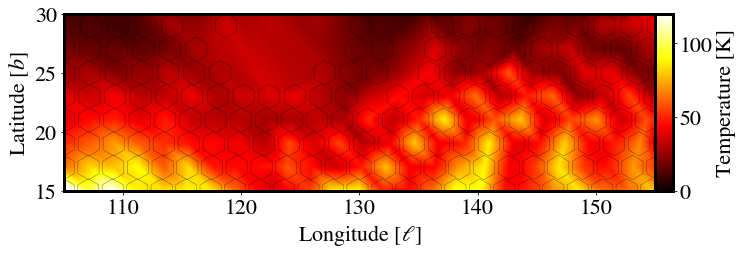

In [96]:
colors=[(1, 1, 1, 1) for _ in ls]       
f, axes = plt.subplots(1,1, figsize=(16,4))

im1 = axes.imshow(np.max(grid_temps, axis=2), extent=[105,160,15, 50],
               origin="lower",cmap="hot", vmin=0, vmax=120)
axes.scatter(ls, bs, facecolor=colors,edgecolor="black",linewidth=0.5,alpha=0.5,s=600, marker="h")

axes.set_ylim(15,30)
axes.set_xlim(105,155)
axes.set_xlabel("Longitude [$\\ell$]")
axes.set_ylabel("Latitude [$b$]")

plt.colorbar(im1, pad=0, aspect=10, label="Temperature [K]")
plt.tight_layout()
# plt.savefig("TempMap.pdf", dpi=300, bbox_inches="tight")
plt.show()

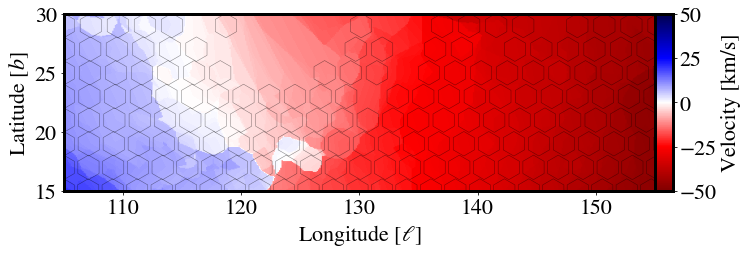

In [98]:
colors=[(1, 1, 1, 1) for _ in ls]

f, axes = plt.subplots(1,1, figsize=(16,4))
im2 = axes.imshow(vel_vals, extent=[105,160,15, 50],
               origin="lower",
                aspect="equal",cmap="seismic_r",
                vmin=-50, vmax=50)

axes.scatter(ls, bs, facecolor=colors,edgecolor="black",linewidth=0.5,alpha=0.5,s=600, marker="h")

axes.set_ylim(15,30)
axes.set_xlim(105,155)
axes.set_xlabel("Longitude [$\\ell$]")
axes.set_ylabel("Latitude [$b$]")

plt.colorbar(im2, pad=0, aspect=10, label="Velocity [km/s]")
plt.tight_layout()
# plt.savefig("VelocityMap.pdf", dpi=300, bbox_inches="tight")
plt.show()


# Column Density Stuff

In [120]:
def calc_peak_gaussian(observation):
    
    """
    A function to compute the Temperature [K] and Velocity [km/s] 
    at the peak using a gaussian fit.
    """
    
    data = data_dict[observation]
    
    main_data = data[0]
    on_data = data[1]
    off_data = data[2]
    
    velocities,correction = calc_velocities(observation)
    
    fitting_indeces = np.where((velocities > -100) & (velocities < 100)) # we zoom in to ignore the ripples
    G = calc_gain(observation)
    
    median = np.median(main_data[fitting_indeces]/off_data[fitting_indeces]) 
    
    y_data_fit = (main_data/off_data)*G - G*median
    y_data_fit = y_data_fit[fitting_indeces]
    x_data_fit = velocities + correction
    x_data_fit = x_data_fit[fitting_indeces]
    

    fit_params = ugradio.gauss.gaussfit(x_data_fit, 
                                        y_data_fit, 
                                        amp=np.max(y_data_fit),
                                        avg=x_data_fit[np.argmax(y_data_fit)],
                                        sig=10) #get fit
    
    
    
    chisq_r_s = (np.sum(np.abs(y_data_fit - 
                                   ugradio.gauss.gaussval(x_data_fit, **fit_params))**2)
                                 / (y_data_fit.size - 3) / 10**2)
  

    
    T, vel, sigma = fit_params['amp'][0], fit_params['avg'][0], fit_params['sig'][0]
                 
    return T,vel,sigma,chisq_r_s

def calc_mass(observation):
    """
    A function that calculates the expected mass along a line of sight.
    """
    T,vel,sigma,chisq_r_s = calc_peak_gaussian(observation)
    
    Ω_beam = 2 * (np.pi/180)**2 #to stradians
    Δv = (np.abs(sigma * astropy.units.km/astropy.units.s).to(astropy.units.cm / astropy.units.s)).value / 2
    m_H = ((astropy.constants.m_p + astropy.constants.m_p).to(astropy.units.g)).value
    d = ((100 * astropy.units.pc).to(astropy.units.cm)).value
    value = (1.8e18 * m_H * d**2 * Δv * T * Ω_beam) * astropy.units.g
    
    return value.to(astropy.units.solMass)


In [125]:
calc_mass(coord)

<Quantity 1746027.48066573 solMass>

In [123]:
# total_mass = 0
# for coord in data_dict.keys():
#     M = calc_mass(coord)
#     total_mass += M

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [119]:
calc_mass((ls[0], bs[0]))

9.352207437502951


<Quantity 373753.92633057 solMass>

In [124]:
total_mass

<Quantity 1.20237291e+09 solMass>

In [125]:

# colors[:,-1] = Ts/np.max(Ts)

# colors_vals[1]

# print(grid_vels)

# cmap = plt.cm.bwr_r #choose cmap
# n = len(spectra[0]) #number of colormap sample points to choose from

# colors_vals = cmap(np.linspace(0,1,n)) # sampling n different colors from the colormap
# max_temp = np.max(grid)


# n_min, n_max = 220, 550
# n_min, n_max = 0, n

# plt.figure(figsize=(10,5))
# im = plt.imshow(grid[:,:,0], alpha=0.5, vmin=-50, vmax=50, cmap="bwr_r")
# for i in range(n_min, n_max):
#     cmap = colors.ListedColormap(colors_vals[i]) #we set a given frequency to a color
#     bounds=[-200,200]
#     norm = colors.BoundaryNorm(bounds, cmap.N)
#     plt.imshow(grid[:,:,i], alpha=grid[:,:,i]/max_temp, extent=[105,160,15, 50],
#                origin="lower", aspect="equal",cmap=cmap, norm=norm)
    


# plt.colorbar(im, pad=0, aspect=10, label="Velocity [km/s]")
# plt.xlabel("Longitude [$\\ell$]")
# plt.ylabel("Latitude [$b$]")
# # plt.plot(grid[0,0,:])
# plt.show()




In [143]:

# plt.scatter(ls,bs, c=Ts, cmap="hot", s=250, marker="H")
# plt.colorbar()
# plt.show()


# plt.scatter(ls,bs, c=colors, s=250, marker="H",vmin=-50, vmax=50)
# # plt.colorbar()
# plt.show()

# # plt.scatter(ls,bs, c=χs, cmap="gray", s=250, marker="H")
# # plt.colorbar()
# # plt.show()

In [144]:



# grid = griddata(coords, np.array(Ts), (grid_x, grid_y), method='nearest')

# fig, ax = plt.subplots(1,1,figsize=(10,5))

# im = ax.imshow(grid, origin="lower",extent=[105,160,15, 50], aspect="equal", cmap="hot")
# plt.colorbar(im, pad=0, aspect=15, label="Temperature [K]")
# ax.set_xlabel("Longitude [$\\ell$]")
# ax.set_ylabel("Latitude [$b$]")
# plt.show()

# cmap = plt.cm.bwr_r #choose cmap
# n = len(ls) #number of colormap sample points to choose from
# colors = cmap(Vs) # sampling n different colors from the colormap
# colors[:,-1] = Ts/np.max(Ts)

# grid = griddata(coords, colors, (grid_x, grid_y), method='nearest')

# fig, ax = plt.subplots(1,1,figsize=(10,5))

# im = ax.imshow(grid, origin="lower",extent=[105,160,15, 50], aspect="equal", cmap="bwr_r")
# # plt.colorbar(im, pad=0, aspect=15, label="Temperature [K]")
# ax.set_xlabel("Longitude [$\\ell$]")
# ax.set_ylabel("Latitude [$b$]")
# plt.show()

In [ ]:
1 + 2

In [126]:
ugradio.gauss.gaussfit??